In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from prophet import Prophet
from openpyxl.workbook import Workbook
from matplotlib import pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import cx_Oracle
from config import oracle_wfm_key
import time
import datetime as dt
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy.types import String
import ipynbname
from tqdm import tqdm
import itertools
import databases as db

ods = db.oracle('cco_wfm',oracle_wfm_key)

file = ipynbname.name()
output_path=r'\\Tds\Metrocom\Contact Center\Workforce Management\Forecasting Models\Forecast Outputs\\'

In [2]:
service = ['Business FS Bend Cable','FS','Financial Services Bus']
yesterday = dt.date.today() - dt.timedelta(days=1)
appended_data = []
for name in service:
    query = f'''SELECT "A1"."DateTime",
                "A1"."Queue",
                "A1"."Forecasted_AHT",
                "A1"."Forecasted_CV",
                "A1"."Actual_AHT",
                "A1"."Actual_CV"
        FROM "CCO_WFM"."Queue_Analytics" "A1"
        WHERE "A1"."Queue" = '{name}'
            AND "A1"."DateTime" <= TO_DATE('{yesterday}','YYYY-MM-DD')'''
    data = pd.read_sql(query, ods)
    appended_data.append(data)
appended_data = pd.concat(appended_data)
appended_data.head(3)

DateTime                   Queue  Forecasted_AHT  Forecasted_CV  \
0 2022-07-25 01:15:00  Business FS Bend Cable             NaN            NaN   
1 2022-07-25 01:30:00  Business FS Bend Cable             NaN            NaN   
2 2022-07-25 01:45:00  Business FS Bend Cable             NaN            NaN   

   Actual_AHT  Actual_CV  
0         0.0        0.0  
1         0.0        0.0  
2         0.0        0.0

In [3]:
# remove duplicated data
appended_data['Actual_CV'].mask((appended_data['Queue'] == 'Business FS Bend Cable') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)
appended_data['Actual_CV'].mask((appended_data['Queue'] == 'FS') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)

appended_data['Forecasted_CV'].mask((appended_data['Queue'] == 'Business FS Bend Cable') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)
appended_data['Forecasted_CV'].mask((appended_data['Queue'] == 'FS') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)

appended_data['Actual_AHT'].mask((appended_data['Queue'] == 'Business FS Bend Cable') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)
appended_data['Actual_AHT'].mask((appended_data['Queue'] == 'FS') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)

appended_data['Forecasted_AHT'].mask((appended_data['Queue'] == 'Business FS Bend Cable') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)
appended_data['Forecasted_AHT'].mask((appended_data['Queue'] == 'FS') & 
                                   (appended_data['DateTime'] >= '2021-01-24'),0,inplace=True)

## Volume Forecasts

In [4]:
grouped_cv = appended_data.groupby(['DateTime'])['Actual_CV'].sum()
grouped_cv = grouped_cv.reset_index()
grouped_cv.head(3)

DateTime  Actual_CV
0 2017-01-02 07:00:00        0.0
1 2017-01-02 07:15:00        0.0
2 2017-01-02 07:30:00        1.0

In [5]:
weekly_cv = grouped_cv.resample('W', on='DateTime').sum()
weekly_cv.head(3)

Actual_CV
DateTime             
2017-01-08      637.0
2017-01-15      669.0
2017-01-22      705.0

In [6]:
grouped_fcv = appended_data.groupby(['DateTime'])['Forecasted_CV'].sum()
grouped_fcv = grouped_fcv.reset_index()
grouped_fcv.head(3)

DateTime  Forecasted_CV
0 2017-01-02 07:00:00            1.0
1 2017-01-02 07:15:00            1.0
2 2017-01-02 07:30:00            0.0

In [7]:
weekly_fcv = grouped_fcv.resample('W', on='DateTime').sum()
weekly_fcv.head(3)

Forecasted_CV
DateTime                 
2017-01-08          528.0
2017-01-15          622.0
2017-01-22          657.0

In [8]:
column_names = ['ds','for_y']
weekly_for = weekly_fcv.reset_index()
weekly_for.columns = column_names
weekly_for = weekly_for.replace(0,np.nan)
weekly_for.tail(3)

ds  for_y
293 2022-08-21  637.0
294 2022-08-28  646.0
295 2022-09-04    NaN

In [9]:
column_names = ['ds','y']
weekly_data = weekly_cv.reset_index()
weekly_data.columns = column_names
weekly_data = weekly_data.replace(0,np.nan)
weekly_data.tail(3)

ds      y
293 2022-08-21  601.0
294 2022-08-28  621.0
295 2022-09-04    NaN

#### Initiate Prophet

In [10]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
future = m.make_future_dataframe(periods=104, freq='W')
future.tail(3)

ds
397 2024-08-18
398 2024-08-25
399 2024-09-01

In [12]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds        yhat  yhat_lower  yhat_upper
397 2024-08-18  667.004099  557.739707  787.278759
398 2024-08-25  654.639019  543.457742  759.199577
399 2024-09-01  634.077267  527.751423  738.911799

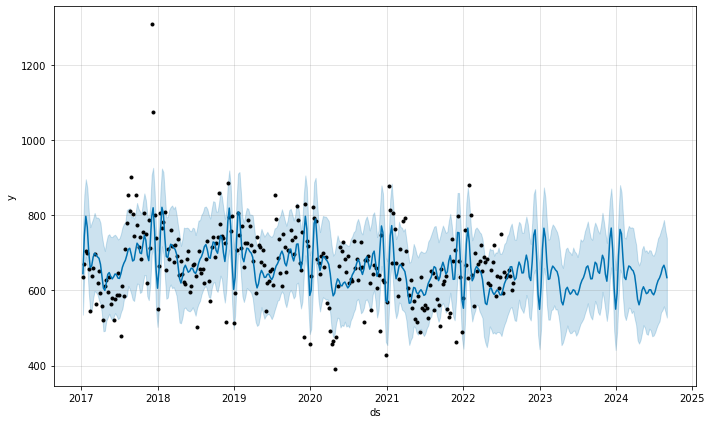

In [13]:
fig1 = m.plot(forecast)

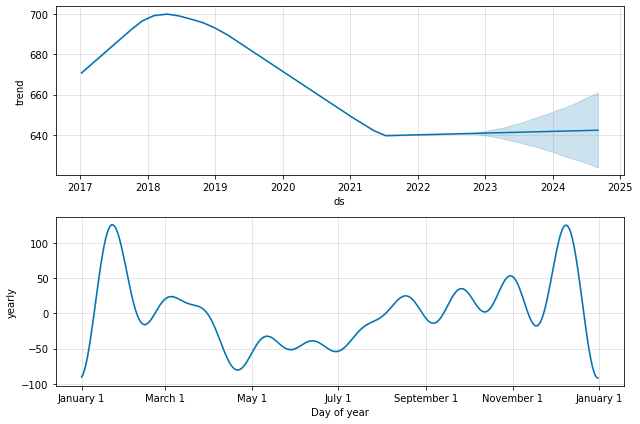

In [14]:
fig2 = m.plot_components(forecast)


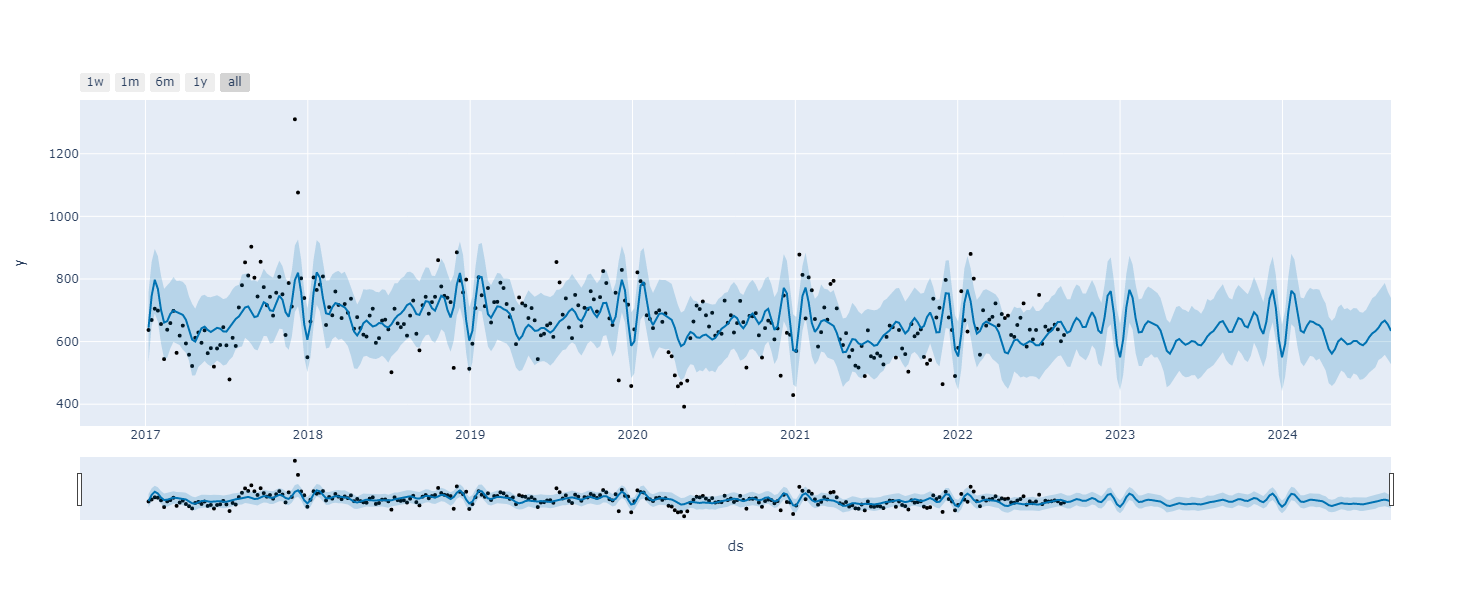

In [15]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

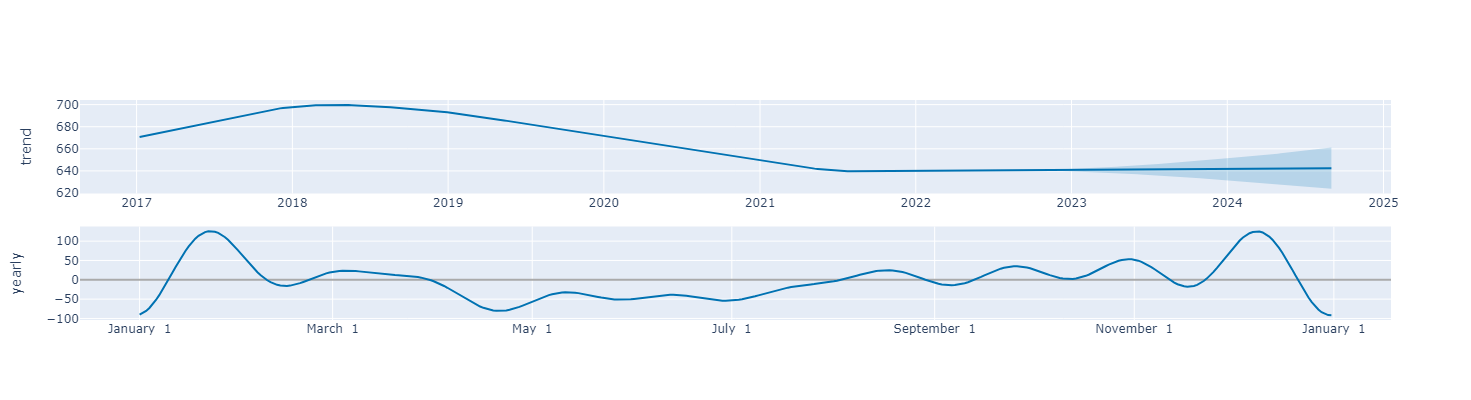

In [16]:
plot_components_plotly(m, forecast)


In [17]:
forecast.tail(3)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
397 2024-08-18  642.285660  557.739707  787.278759   624.343200   660.473341   
398 2024-08-25  642.302012  543.457742  759.199577   624.016910   660.795675   
399 2024-09-01  642.318364  527.751423  738.911799   623.808876   661.134559   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
397       24.718439             24.718439             24.718439  24.718439   
398       12.337007             12.337007             12.337007  12.337007   
399       -8.241097             -8.241097             -8.241097  -8.241097   

     yearly_lower  yearly_upper  multiplicative_terms  \
397     24.718439     24.718439                   0.0   
398     12.337007     12.337007                   0.0   
399     -8.241097     -8.241097                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
397                         0.0                         0.0  667.004099  
398                         0.0                         0.0  654.639019  
399                         0.0                         0.0  634.077267

#### Cross Validation

In [18]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 41 forecasts with cutoffs between 2021-01-15 00:00:00 and 2022-07-29 00:00:00


  0%|          | 0/41 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper      y     cutoff
0 2021-01-17  727.107094  626.107592  824.080784  813.0 2021-01-15
1 2021-01-24  734.378012  640.877706  841.729835  674.0 2021-01-15
2 2021-01-31  661.746248  558.145624  760.279396  805.0 2021-01-15

In [19]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon          mse       rmse        mae      mape     mdape     smape  \
0  2 days  8703.636845  93.293284  76.643055  0.116683  0.105649  0.120269   
1  9 days  8920.431333  94.448035  74.072894  0.115691  0.092513  0.118235   
2 16 days  9439.654617  97.157885  80.084913  0.123157  0.111949  0.127173   

   coverage  
0  0.682927  
1  0.756098  
2  0.682927

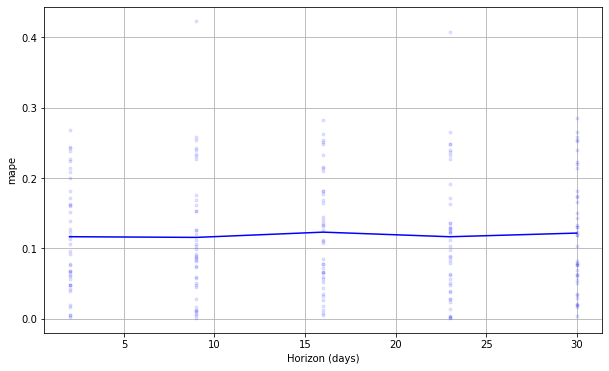

In [20]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

### SQL Export

In [21]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# add filename as column
team = file.split('.')[0]
forecast = forecast.merge(weekly_data, on='ds',how='left')
forecast = forecast.merge(weekly_for, on='ds',how='left')
forecast['Team'] = team

# determine last row
last_row = forecast['ds'].max()
end_date = f"'{last_row}'"

# remove duplicate rows before insert
delete = f'''DELETE FROM
                    "CCO_WFM"."Forecasts_Weekly" "A1"
                WHERE
                    "A1"."Team" = '{team}'
                    
                    AND "A1"."DS" <= TO_DATE({end_date},'YYYY-MM-DD HH24:MI:SS')'''

with ods as conn:
    conn.execute(delete)

In [22]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# Import forecast to database
rows_imported = 0
start_time = time.time()

cols = forecast.dtypes[forecast.dtypes=='object'].index
type_mapping = {col : String(100) for col in cols }

print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
forecast.to_sql('Forecasts_Weekly',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
rows_imported += len(df)

end_time = time.time() - start_time
print(f'Done. {end_time} total seconds have elapsed.')

importing rows 0 to 400...Done. 0.15799188613891602 total seconds have elapsed.


## AHT Forecasts

In [23]:
appended_data['Adj_AHT'] = appended_data['Actual_AHT'] * appended_data['Actual_CV']
appended_data['Adj_AHT'] = appended_data['Adj_AHT'].replace(0, np.nan)
grouped_aht = appended_data.groupby(['DateTime'])['Adj_AHT'].sum()
grouped_aht = grouped_aht.reset_index()
grouped_aht.head(3)

DateTime  Adj_AHT
0 2017-01-02 07:00:00      0.0
1 2017-01-02 07:15:00      0.0
2 2017-01-02 07:30:00    467.0

In [24]:
combined_aht = grouped_aht
combined_aht['Actual_AHT'] = grouped_aht['Adj_AHT'] / grouped_cv['Actual_CV']
combined_aht.head(3)

DateTime  Adj_AHT  Actual_AHT
0 2017-01-02 07:00:00      0.0         NaN
1 2017-01-02 07:15:00      0.0         NaN
2 2017-01-02 07:30:00    467.0       467.0

In [25]:
subdaily_adj = grouped_aht[['DateTime','Adj_AHT']]
subdaily_adj['Adj_AHT'] = subdaily_adj['Adj_AHT'].replace(0, np.nan)
weekly_adj = subdaily_adj.resample('W', on='DateTime').sum()
weekly_adj.head(3)

C:\Users\usrocu\AppData\Local\Temp\ipykernel_9204\3997668832.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Adj_AHT
DateTime            
2017-01-08  267252.0
2017-01-15  272944.0
2017-01-22  291865.0

In [26]:
subdaily_cv = grouped_cv[['DateTime','Actual_CV']]
weekly_cv = subdaily_cv.resample('W', on='DateTime').sum()
weekly_cv.head(3)

Actual_CV
DateTime             
2017-01-08      637.0
2017-01-15      669.0
2017-01-22      705.0

In [27]:
combined_aht = weekly_adj.drop(columns=['Adj_AHT'])
combined_aht['Actual_AHT'] = weekly_adj['Adj_AHT'] / weekly_cv['Actual_CV']
column_names = ['ds','y']
weekly_data = combined_aht.reset_index()
weekly_data.columns = column_names
weekly_data.tail(3)

ds           y
293 2022-08-21  451.329451
294 2022-08-28  448.668277
295 2022-09-04         NaN

In [28]:
appended_data['Adj_for'] = appended_data['Forecasted_AHT'] * appended_data['Forecasted_CV']
appended_data['Adj_for'] = appended_data['Adj_for'].replace(0, np.nan)
grouped_for = appended_data.groupby(['DateTime'])['Adj_for'].sum()
grouped_for = grouped_for.reset_index()
grouped_for.head(3)

DateTime  Adj_for
0 2017-01-02 07:00:00    205.0
1 2017-01-02 07:15:00    273.0
2 2017-01-02 07:30:00      0.0

In [29]:
combined_for = grouped_for
combined_for['Forecasted_AHT'] = grouped_for['Adj_for'] / grouped_fcv['Forecasted_CV']
combined_for.head(3)

DateTime  Adj_for  Forecasted_AHT
0 2017-01-02 07:00:00    205.0           205.0
1 2017-01-02 07:15:00    273.0           273.0
2 2017-01-02 07:30:00      0.0             NaN

In [30]:
subdaily_for = grouped_for[['DateTime','Adj_for']]
subdaily_for['Adj_for'] = subdaily_for['Adj_for'].replace(0, np.nan)
weekly_adj_for = subdaily_for.resample('W', on='DateTime').sum()
weekly_adj_for.head(3)

C:\Users\usrocu\AppData\Local\Temp\ipykernel_9204\494036227.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Adj_for
DateTime            
2017-01-08  214703.0
2017-01-15  261679.0
2017-01-22  299966.0

In [31]:
subdaily_fcv = grouped_fcv[['DateTime','Forecasted_CV']]
weekly_fcv = subdaily_fcv.resample('W', on='DateTime').sum()
weekly_fcv.head(3)

Forecasted_CV
DateTime                 
2017-01-08          528.0
2017-01-15          622.0
2017-01-22          657.0

In [32]:
combined_for = weekly_adj_for.drop(columns=['Adj_for'])
combined_for['Forecasted_AHT'] = weekly_adj_for['Adj_for'] / weekly_fcv['Forecasted_CV']
column_names = ['ds','for_y']
weekly_for_aht = combined_for.reset_index()
weekly_for_aht.columns = column_names
weekly_for_aht.tail(3)

ds       for_y
293 2022-08-21  464.998430
294 2022-08-28  464.244582
295 2022-09-04         NaN

#### Initiate Prophet

In [33]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
future = m.make_future_dataframe(periods=104, freq='W')
future.tail(3)

ds
397 2024-08-18
398 2024-08-25
399 2024-09-01

In [35]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds        yhat  yhat_lower  yhat_upper
397 2024-08-18  464.352492  434.440599  492.531285
398 2024-08-25  464.541938  434.666488  494.103455
399 2024-09-01  467.201784  435.347939  496.483295

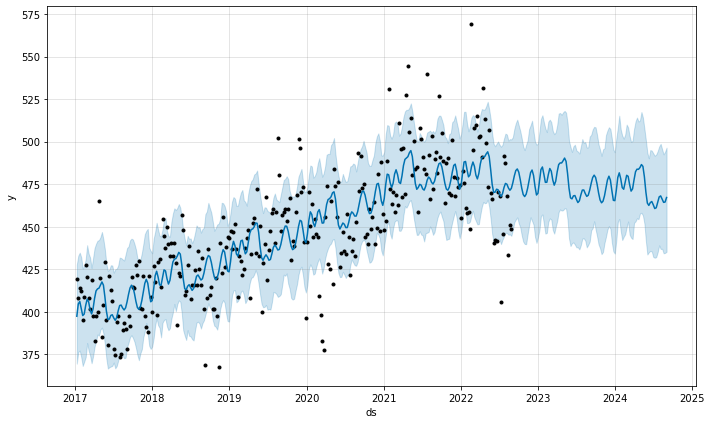

In [36]:
fig1 = m.plot(forecast)

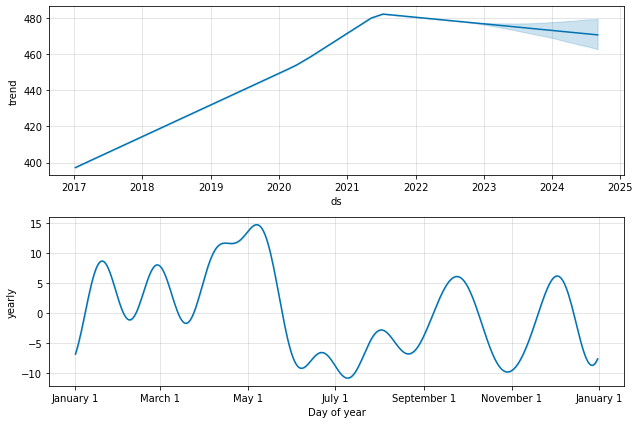

In [37]:
fig2 = m.plot_components(forecast)


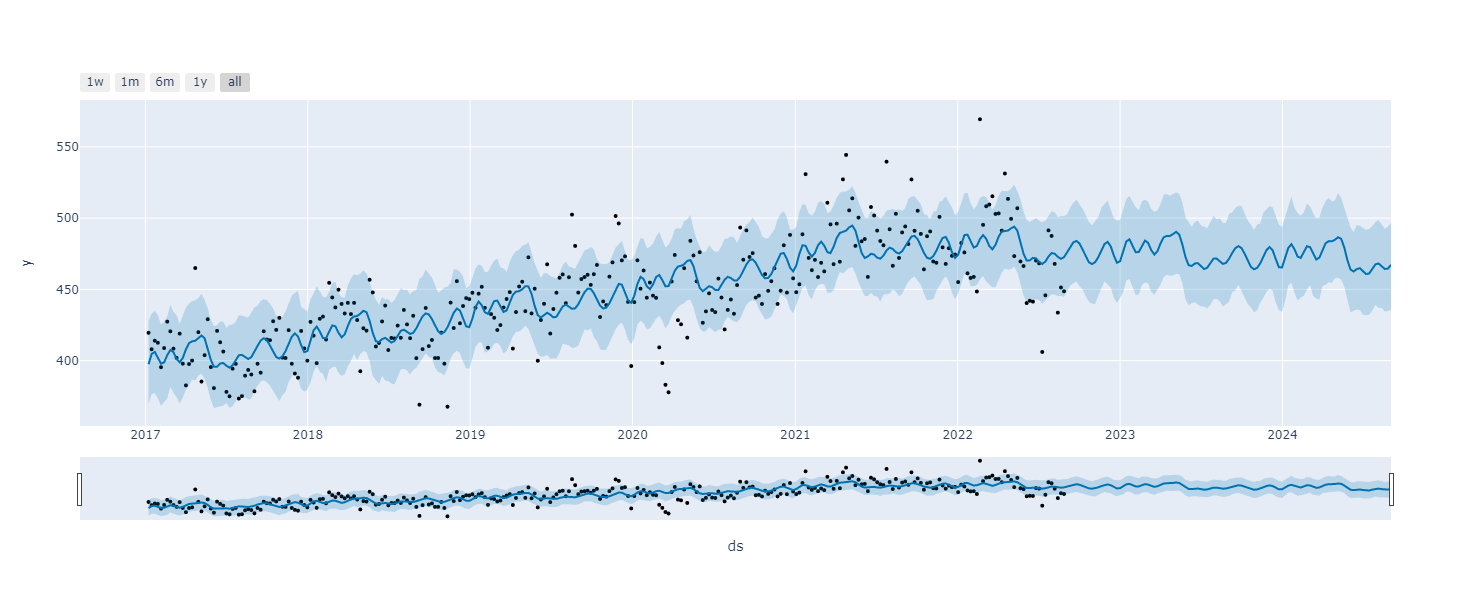

In [38]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

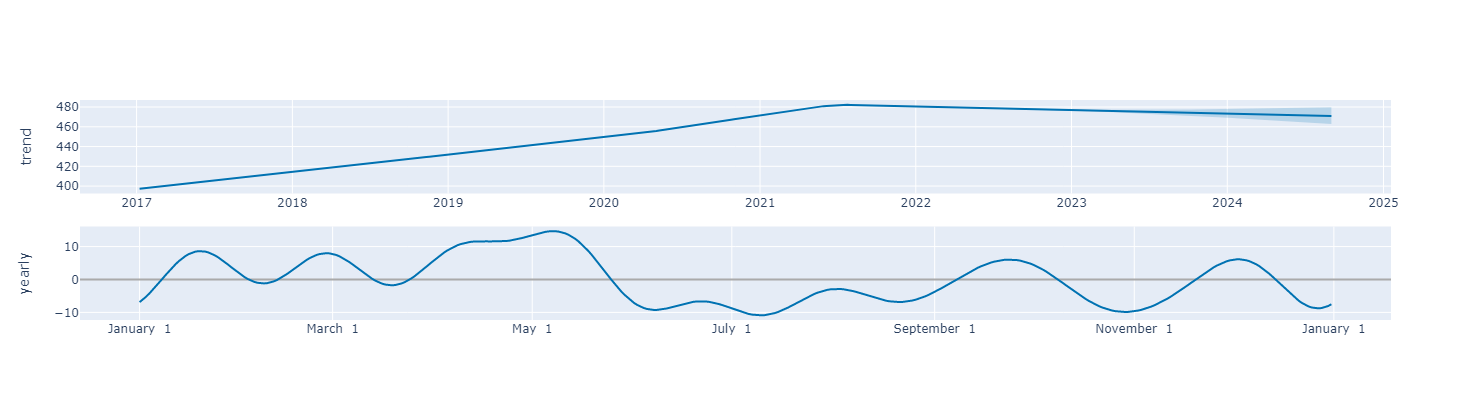

In [39]:
plot_components_plotly(m, forecast)


In [40]:
forecast.tail(3)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
397 2024-08-18  470.993368  434.440599  492.531285   463.325316   479.609735   
398 2024-08-25  470.922998  434.666488  494.103455   463.089975   479.637582   
399 2024-09-01  470.852628  435.347939  496.483295   462.908542   479.744156   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
397       -6.640876             -6.640876             -6.640876 -6.640876   
398       -6.381060             -6.381060             -6.381060 -6.381060   
399       -3.650844             -3.650844             -3.650844 -3.650844   

     yearly_lower  yearly_upper  multiplicative_terms  \
397     -6.640876     -6.640876                   0.0   
398     -6.381060     -6.381060                   0.0   
399     -3.650844     -3.650844                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
397                         0.0                         0.0  464.352492  
398                         0.0                         0.0  464.541938  
399                         0.0                         0.0  467.201784

#### Cross Validate

In [41]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 41 forecasts with cutoffs between 2021-01-15 00:00:00 and 2022-07-29 00:00:00


  0%|          | 0/41 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2021-01-17  467.932039  442.929256  492.059413  488.642066 2021-01-15
1 2021-01-24  466.527061  440.722657  493.894488  530.842730 2021-01-15
2 2021-01-31  462.408932  436.330052  487.056621  472.062112 2021-01-15

In [42]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon          mse       rmse        mae      mape     mdape     smape  \
0  2 days   714.042139  26.721567  19.992833  0.041805  0.029024  0.041301   
1  9 days  1072.992744  32.756568  25.548381  0.052537  0.047211  0.052337   
2 16 days   921.312216  30.353125  23.100027  0.048681  0.030046  0.047810   

   coverage  
0  0.682927  
1  0.658537  
2  0.634146

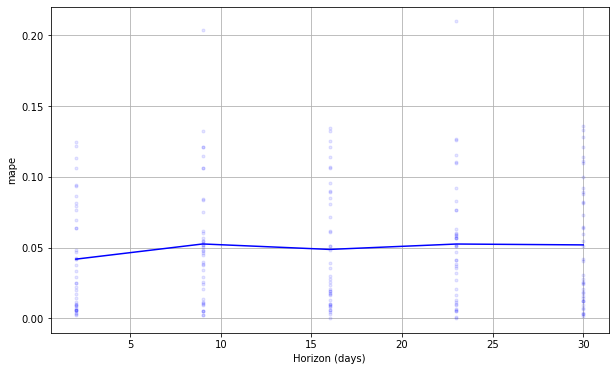

In [43]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [44]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# add filename as column
team = file.split('.')[0]
forecast = forecast.merge(weekly_data, on='ds',how='left')
forecast = forecast.merge(weekly_for_aht, on='ds',how='left')
forecast['Team'] = team

# determine last row
last_row = forecast['ds'].max()
end_date = f"'{last_row}'"

# remove duplicate rows before insert
delete = f'''DELETE FROM
                    "CCO_WFM"."Forecasts_Weekly_AHT" "A1"
                WHERE
                    "A1"."Team" = '{team}'
                    
                    AND "A1"."DS" <= TO_DATE({end_date},'YYYY-MM-DD HH24:MI:SS')'''

with ods as conn:
    conn.execute(delete)

In [45]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
# Import forecast to database
rows_imported = 0
start_time = time.time()

cols = forecast.dtypes[forecast.dtypes=='object'].index
type_mapping = {col : String(100) for col in cols }

print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
forecast.to_sql('Forecasts_Weekly_AHT',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
rows_imported += len(df)

end_time = time.time() - start_time
print(f'Done. {end_time} total seconds have elapsed.')

importing rows 0 to 400...Done. 0.09700822830200195 total seconds have elapsed.
